# PINN solver for Conduction-Convection problem using sequential stress-split training 

Check out our paper for more details: 
**Physics-informed neural network solution of thermo-hydro-mechanical (THM) processes in porous media**

Find the paper at: [https://arxiv.org/abs/2203.01514](https://arxiv.org/abs/2203.01514)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_THM_ConductionConvection.ipynb)


Cite our work:
```
@article{amini2022physics,
  title={Physics-informed neural network solution of thermo-hydro-mechanical (THM) processes in porous media},
  author={Amini, Danial and Haghighat, Ehsan and Juanes, Ruben},
  journal={arXiv preprint arXiv:2203.01514},
  year={2022}
}
```

In [44]:
!pip install sciann==0.6.5.1 -q 

In [45]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff
import os, time 
import matplotlib.pyplot as plt

In [46]:
#@title Data Generator to train PINN solver
# #@title Data generator block  
class DataGeneratorXT:
  """ Generates 1D time-dependent collocation grid for training PINNs
  Taken from here: https://github.com/sciann/sciann-applications/tree/master/SciANN-DataGenerator 
  # Arguments:
    X: [X0, X1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs. 
        ('domain', 'ic', 'bc-left', 'bc-right', 'all')
    num_sample: total number of collocation points. 
    logT: generate random samples logarithmic in time. 
  # Examples: 
    >> dg = DataGeneratorXT([0., 1.], [0., 1.], ["domain", "ic", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()
  """
  def __init__(self, 
               X=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right'], 
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)
    
    counter = 0
    # domain points 
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter 
    counter += ids_ic.size

    # bc points 
    num_sample_per_edge = int(num_sample/2)
    # left bc points 
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points 
    x_bc_right = np.full(num_sample-num_sample_per_edge, self.Xdomain[1])
    t_bc_right = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter 
    counter += ids_bc_right.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom, 
        'bc-left': ids_bc_left, 
        'bc-right': ids_bc_right,
        'ic': ids_ic,
        'bc': ids_bc, 
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )
      
    return input_data, target_data

  def get_test_grid(self, Nx=200, Nt=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      t_data = self.input_data[1][ids,:]
      plt.scatter(x_data, t_data)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        t_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, t_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()

In [47]:
# Unit conversions 
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [48]:
# ----------------------- Constant Parameters----------------------
DTYPE = 'float32'
phi = 0.5
rho_s = 2000.0 * kg/m**3
rho_f = 1000. * kg/m**3
mu = 1e-3
k = 1.98e-5
beta_s = 0.0
beta_f = 0.0
b = 1.0
Ly = 0.1*m
C_s = 0.201
C_f = 0.201
rho_C_avg = (1-phi)*rho_s*C_s + phi*rho_f*C_f
Lambda_avg = 2.6

# ----------------------- Dimensionless parameters -----------------------
p_star = 1 *Pa
x_star = Ly
t_star = 0.5*s
T_star = 100
td_0 = 0.0 
td_f = 0.5*s/t_star 
yd_min = 0.0 
yd_max = (Ly/x_star) 
rho_C_bar = rho_C_avg

beta_s_f = (b-phi)*beta_s + phi*beta_f
C_star = rho_C_avg/rho_C_bar      
J_star = k*p_star*t_star/(mu*(x_star**2))   
F_star = (Lambda_avg*t_star)/(rho_C_bar*(x_star**2))

In [49]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(124)

yd = sn.Variable('yd', dtype=DTYPE)
td = sn.Variable('td', dtype=DTYPE)

# NOTE: For better accuracy, increase size of the network, e.g. 8*[40]
Td = sn.Functional('Td', [yd, td], 4*[20], 'tanh')

y = yd*x_star    
t = td*t_star      
T = Td*T_star

Td_weights = Td.get_weights().copy()

In [50]:
#-----------training parameters-------------
NUM_SAMPLES = 20000
BATCH_SIZE = 500
EPOCHS = 200 #1000 <- Incease for better accuracy!
STOP_AFTER = None

ADAPTIVE_WEIGHTS = {'method': 'NTK', 'freq':200}

initial_lr = 1e-3
final_lr = initial_lr/100

LEARNING_RATE = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
     "decay_epochs": EPOCHS
}

dg_energy = DataGeneratorXT(
    X=[yd_min, yd_max], T=[td_0,td_f], 
    num_sample=NUM_SAMPLES,
    targets=['domain', 'ic', 'bc-left', 'bc-right']
)
input_data_energy, target_data_energy = dg_energy.get_data()

In [51]:
#@title custom plot functions 

def cust_semilogx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.semilogy(Y, label=line_label)
    else:
        im = AX.semilogy(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

In [52]:
#@title Postprocessing data 
#-----------grid for evaluation of the trained model-------------

log10p = lambda x: np.log10(1. + x)
Ny, Nt = 100, 301
ys = np.linspace(yd_min, yd_max, Ny)
ys_lineplot = ys
ts_logT = (np.logspace(log10p(td_0*t_star), log10p(td_f*t_star), Nt*3)-1.0)/t_star
ts_lineplot = [0.01*s/t_star, 0.05*s/t_star, 0.5*s/t_star]

input_test_lineplot = np.meshgrid(ys_lineplot, ts_lineplot, indexing='ij')

#------plot setting-----
ms = 3  # markersize
mk = 1  #  markevery
kwrds_plot = {'ms': ms, 'markevery': mk, 'ls': ''}
kwrds_training = {'adaptive_weights': ADAPTIVE_WEIGHTS}  
legend_settings = {
    'bbox_to_anchor': (1.005, 0.75),
    'loc': 'upper left', 
    'fontsize': 'small',
    'fancybox': True, 
    'frameon': False
}
case_num = ["I", "II", "III"]
marker = ['v', 'o', 's']
color = ['blue', 'orange', 'red']

In [53]:
#@title Post processing (plotting) functions  

def plot_loss_history(H_energy):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    for key, val in H_energy.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[0], None, np.array(val)/val[0], "Epoch", "Energy", "L/L0", key)
    ax[0].legend(loc="upper right")
    cust_semilogx(ax[1], None, np.array(H_energy.history["lr"]), "Epoch",None, "lr")
    cust_semilogx(ax[2], None, np.array(H_energy.history["loss"]), "Epoch", None, "Total Loss")
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('loss.jpg', dpi=150) 
    plt.show()
    plt.close()


def plot_results(PINN):
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    y_plot = ys_lineplot*x_star
    for i in np.arange(3):
        ax.plot(PINN[:,i], y_plot, color=color[i])
        
    ax.text(10, 0.086, 't=0.01(s)', rotation=15)
    ax.text(10, 0.065, 't=0.05(s)', rotation=32)
    ax.text(32, 0.04, 't=0.5(s)', rotation=42)

    fig.subplots_adjust(left=0.125, right=0.75, bottom=0.125, top=0.925, wspace=0.25, hspace=0.2)
    ax.legend(**legend_settings)
    ax.set_ylabel('Height (m)')
    ax.grid(ls='--')
    ax.set_xlabel('Temperature (${{}^o C}$)')
    plt.savefig('results.jpg',dpi=150)
    plt.show()
    plt.close()

In [54]:
#---------training---------

pd_yd = 1.0 # Change this to recover all curves: [0., 1., -1.]

loss_energy, lr_energy, time_energy = [], [], []

start_time = time.time()

#-----energy eq., IC, and BC------

Eq_T = sn.rename(C_star*diff(Td,td) - J_star*(rho_f*C_f/rho_C_bar)*pd_yd*diff(Td,yd) - F_star*diff(Td, yd, order=2), "Eq_T")

IC = sn.rename(abs(Td), "IC")
BC_1 = sn.rename(abs(Td), "BC_1")
BC_2 = sn.rename(abs(Td - 100/T_star), "BC_2")

targets_energy = [Eq_T, IC, BC_1, BC_2] 

# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([yd,td], [Td])
energy = sn.SciModel([yd,td], targets_energy)

#----------------training----------
H_energy = energy.train(
    input_data_energy,
    target_data_energy,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    stop_loss_value=1e-8,
    stop_after=STOP_AFTER,
    verbose=0,
    **kwrds_training
)

energy.save_weights('trained_weights.hdf5')

loss_energy += H_energy.history["loss"]
lr_energy += H_energy.history["lr"]
time_energy += H_energy.history["time"]

print('\n run time is {} \n'.format(time.time()-start_time))
PINN = Td.eval(model_pred, input_test_lineplot)*T_star
    


Total samples: 20000 
Batch size: 64 
Total batches: 313 


+ NTK evaluation time [s]: 1.0214378833770752 

+ adaptive_weights at epoch 1: [0.2270539812634686, 0.7358366511153939, 1.5071681646097872, 1.5299412030113504]

 run time is 234.12968826293945 



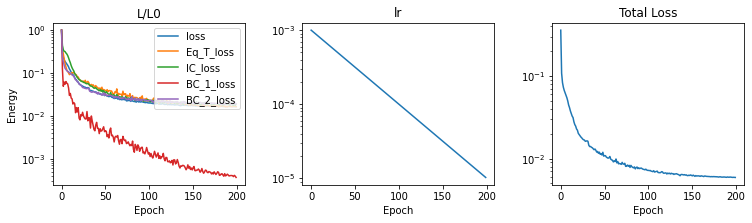

In [55]:
plot_loss_history(H_energy)

No handles with labels found to put in legend.


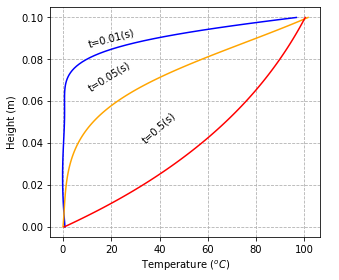

In [56]:
plot_results(PINN)